<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/gita_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bevezetés a gépi tanulási módszerek alkalmazásába

Workshop

Gita Műszaki Térinformatika Egyesület konferenciája, 2024. április 25-26, Esztergom, Szent Adalbert Rendezvény Központ

Összeállította: Siki Zoltán, Hrutka Bence

## Felügyelet nélküli módszerek

### Csoportképzés (klaszterezés) kMeans, DBSCAN

A k-Means egy előre megadott csoportszámra ad egy optimális megoldást úgy, hogy a csoportközéppontok és az egyes elemek között a távolságok minimálisak legyenek.  

A DBSCAN (density-based spatial clustering of applications with noise) algoritmus a pontok sűrűsége alapján előre nem ismert számú csoportot képes kialakítani. Két paramétert szükséges megadni,

- *eps* maximális távolság szomszédos pontok között
- *n_min* mag pontok minimális száma

![DBSCAN](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/dbscan.png?raw=true)

#### Példa véletlenszámmal generált adatok alapján



Kettő dimenzióban adott pontok csoportosítása előre ismeretlen számú csoportba. A Scikit-learn DBSCAN implementációját használjuk.

kMeans Csoportok száma: 4
DBSCAN Csoportok száma: 4
DBSCAN Zaj pontok száma: 90


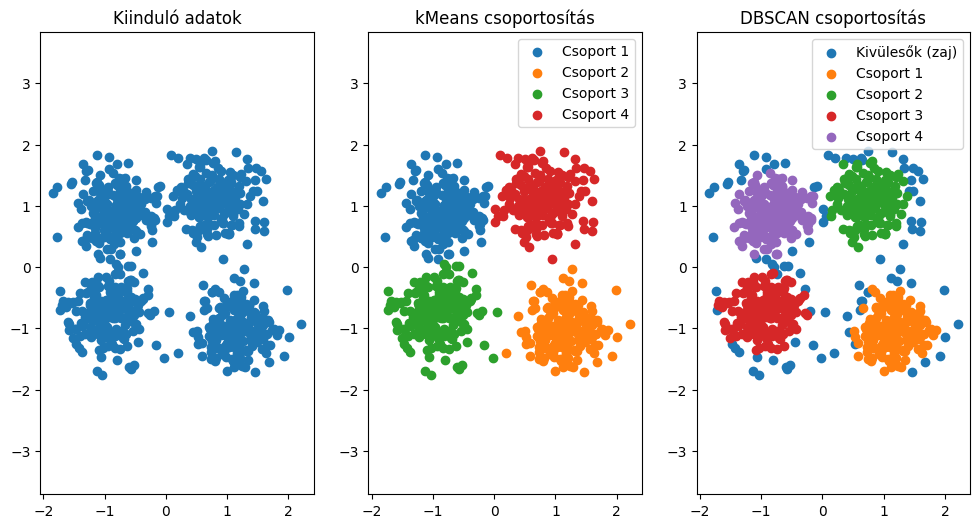

In [1]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from matplotlib import pyplot as plt
from numpy import unique, where

# minta adatok generálása
centers = [[0.8, 1.1], [-0.9, -0.7], [1.1, -1.0], [-0.8, 0.9]]
X, labels_true = make_blobs(
    n_samples=800, centers=centers, cluster_std=0.35, random_state=0)

# csoportok összegyűjtése
km = KMeans(n_clusters=4, n_init=10).fit(X)
db = DBSCAN(eps=0.2, min_samples=10).fit(X)

# Pontok címkéi
labels_km = km.labels_
labels_db = db.labels_

print(f"kMeans Csoportok száma: {len(set(labels_km))}")
print(f"DBSCAN Csoportok száma: {len(set(labels_db))-1}")
print(f"DBSCAN Zaj pontok száma: {list(labels_db).count(-1)}")

# modell illesztés
y_db = db.fit_predict(X)
y_km = km.fit_predict(X)
# csoportok ábrázolása
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
plt.axis('equal')
ax0.set_aspect('equal', adjustable="datalim")
ax0.scatter(X[:,0], X[:,1])
ax0.set_title("Kiinduló adatok")

# kMeans plot
ax1.set_aspect('equal', adjustable="datalim")
for cluster in unique(y_km):
	# csoporthoz tartozók kikeresése és ábrázolása
	row_ix = where(y_km == cluster)
	ax1.scatter(X[row_ix, 0], X[row_ix, 1], label= f"Csoport {cluster+1}" if cluster > -1 else "Kivülesők (zaj)")
# show the plot
ax1.set_title('kMeans csoportosítás')
_ = ax1.legend()

# DBSCAN plot
ax2.set_aspect('equal', adjustable="datalim")
for cluster in unique(y_db):
	# csoporthoz tartozók kikeresése és ábrázolása
	row_ix = where(y_db == cluster)
	ax2.scatter(X[row_ix, 0], X[row_ix, 1], label= f"Csoport {cluster+1}" if cluster > -1 else "Kivülesők (zaj)")
# show the plot
ax2.set_title('DBSCAN csoportosítás')
_ = ax2.legend()

#### Példa pontfelhő pontjainak csoportosítására




Egy épületeket is tartalmazó pontfelhőből az épületek tetőpontjait kigyűjtöttük előzőleg. A pontokat szeretnénk önálló tetőnként csoportosítani (3D-ben).

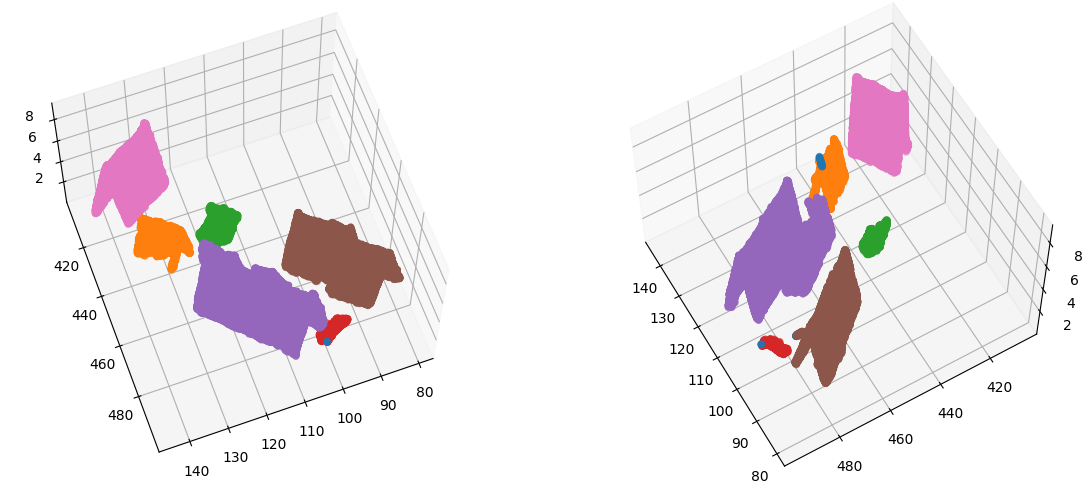

In [2]:
# minta adatok letöltése és kitömörítése
!rm -f barnag_roofs.*
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/barnag_roofs.zip
!unzip -q barnag_roofs.zip

from numpy import unique, where, asarray, loadtxt
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
# pontfelhő betöltése
xyz = loadtxt('barnag_roofs.xyz', dtype='float32', delimiter=' ')
# modell létrehozása
model = DBSCAN(eps=0.60, min_samples=100)
y = model.fit_predict(xyz)
# csoportok ábrázolása
fig = plt.figure(figsize=(14, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
for cluster in unique(y):
	# csoporthoz tartozók kikeresése és ábrázolása
	row_ix = where(y == cluster)
	ax0.scatter(xyz[row_ix, 0], xyz[row_ix, 1], xyz[row_ix, 2])
	ax1.scatter(xyz[row_ix, 0], xyz[row_ix, 1], xyz[row_ix, 2])
ax0.view_init(65, 70)
ax1.view_init(60, 150)

## Felügyelt módszerek



### Gépi tanítási példa borok osztályozására

Ebben a fejezetben a Scikit-Learn nyílt forráskódú Python könyvtárat használjuk. A borok tulajdonságai alapján próbáljuk eldönteni, hogy melyik toszkánai dűlőről származnak.

#### Logisztikus regresszió

A Logisztikus Regresszió a nevével ellentétben egy lineáris osztályozási modell.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    """ Eredmények 2D-s ábrázolása, csak két tulajdonség esetén használható
    """
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # a döntési felület előkészítése
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # osztályok ábrázolása
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # teszt adatok kiemelése
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

dat = datasets.load_wine()
print(f"oszlopok száma: {dat.data.shape[1]}, sorok száma: {dat.data.shape[0]}")
print("\noszlop nevek:")
print(dat.feature_names)
print("\nosztály nevek:")
print(dat.target_names)

oszlopok száma: 13, sorok száma: 178

oszlop nevek:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

osztály nevek:
['class_0' 'class_1' 'class_2']


Az egyszerű ábrázolhatóság kedvéért először csak az első két oszlopot használjuk fel. Szokás, hogy a mért adatokat **X** nevű változóban, a megadott címkéket pedig a **y** nevű változóban tárolják.

In [4]:
# adatok felosztása tanító (70%) és teszt (30%) adatokra
used_features = [0, 1]  # csak az első két oszlop
X = dat.data[:,used_features]
y = dat.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Hozzunk létre egy Logisztikus Regresszió modellt és tanítsuk be a tanító adatokon. Majd vizsgáljuk meg, hogy a tesz adatokon hogyan teljesít és ábrázoljuk az eredményt.

Teszt   adatok pontossága: 75.9%
Tanító  adatok pontossága: 83.1%


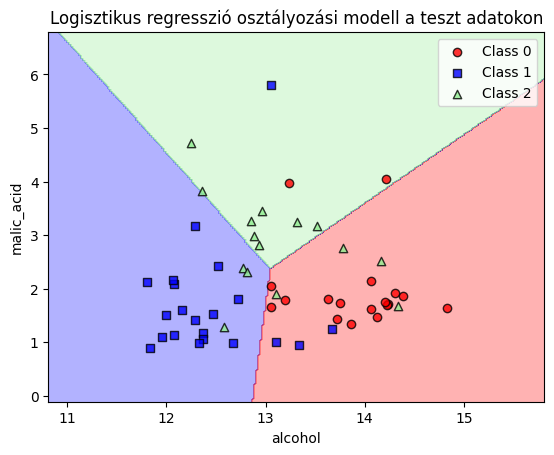

In [5]:
logit = LogisticRegression(max_iter = 2500) # modell létrehozása
logit.fit(X_train, y_train)                 # modell tanítása
y_pred = logit.predict(X_test)              # teszt adatokra a modell becslése
y_train_pred = logit.predict(X_train)       # tanító adatokra a modell becslése
print(f"Teszt   adatok pontossága: {accuracy_score(y_true = y_test, y_pred = y_pred):.1%}")
print(f"Tanító  adatok pontossága: {accuracy_score(y_true = y_train, y_pred = y_train_pred):.1%}")
plot_decision_regions(X_test, y_test, logit)
plt.xlabel(f'{dat["feature_names"][used_features[0]]}')
plt.ylabel(f'{dat["feature_names"][used_features[1]]}')
plt.legend(loc='upper right')
_ = plt.title('Logisztikus regresszió osztályozási modell a teszt adatokon')

Nem is olyan rossz az eredmény, egy kezdő "sommelier"-nél lehet, hogy jobb.

Biztos, hogy az első két oszlop jól jellemzi a borokat? Próbáljuk meg a legjellemzőbb oszlopokat bevenni a model tanításába.

A Logisztikus Regresszió meg tudja határozni az egyes oszlopok fontosságát a modell tanítása közben. Vonjuk be az összes oszlopot és vizsgáljuk meg a fontosságukat!

In [6]:
X = dat.data    # minden oszlopot használunk
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
logit1 = LogisticRegression(max_iter = 2500)
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_test)              # teszt adatokra a modell becslése
y_train_pred = logit1.predict(X_train)       # tanító adatokra a modell becslése
print(f"Teszt adatok pontossága: {accuracy_score(y_true = y_test, y_pred = y_pred):.1%}")
print(f"Tanító adatok pontossága: {accuracy_score(y_true = y_train, y_pred = y_train_pred):.1%}")

importance = logit1.coef_[0]
print("\nOszlopok fontossága")
print("-"*48)
print("Index     Név                       Fontosság")
print("-"*48)
for imp, name, i in sorted(list(zip(importance, dat.feature_names, range(len(dat.feature_names)))), reverse=True):
    print(f"{i:5d} {name:30s} {imp:6.1%}")

Teszt adatok pontossága: 96.3%
Tanító adatok pontossága: 100.0%

Oszlopok fontossága
------------------------------------------------
Index     Név                       Fontosság
------------------------------------------------
    6 flavanoids                      68.5%
   11 od280/od315_of_diluted_wines    50.7%
    0 alcohol                         45.1%
    5 total_phenols                   41.1%
    1 malic_acid                      36.9%
    2 ash                             30.1%
    8 proanthocyanins                 14.4%
    9 color_intensity                 12.3%
   12 proline                          1.1%
   10 hue                              0.8%
    7 nonflavanoid_phenols            -0.3%
    4 magnesium                       -0.9%
    3 alcalinity_of_ash              -39.5%


A negatív fontosság fordított arányosságot jelent.

Nézzük meg az egyes oszlopok érték tartományát is. A gépi tanulási módszerek jobban működnek, ha az adatok közel azonos nagyságrendben helyezkednek el.

In [7]:
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
print("Név                                min      max")
print('-'*48)
for name, mi, ma in zip(dat.feature_names, mins, maxs):
    print(f"{name:30s} {mi:8.2f} {ma:8.2f}")

Név                                min      max
------------------------------------------------
alcohol                           11.03    14.83
malic_acid                         0.74     5.80
ash                                1.36     3.23
alcalinity_of_ash                 10.60    30.00
magnesium                         70.00   162.00
total_phenols                      0.98     3.88
flavanoids                         0.34     5.08
nonflavanoid_phenols               0.13     0.66
proanthocyanins                    0.41     3.58
color_intensity                    1.28    13.00
hue                                0.48     1.71
od280/od315_of_diluted_wines       1.27     4.00
proline                          278.00  1680.00


Készítsünk egy új modellt a legfontosabb hat oszlop(*flavanoids, od280/od315, alcohol, total_phenols, malic_acid, ash*) felhasználásával, ezzel egy dimenzió csökkentést hajtunk végre. Emellett az értékek átskálázásával is próbáljuk javítani a modellt.

In [8]:
X = dat.data[:,[6, 11, 0, 5, 1, 2]] # legfontosabb oszlopok kiválasztása
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
sc = StandardScaler()   # átskálázó létrehozása
sc.fit(X)               # skálázó tanítása az összes adaton
X_train_sc = sc.transform(X_train)  # skálázás végrehajtása a tanító és teszt adatokon
X_test_sc = sc.transform(X_test)
logit2 = LogisticRegression(max_iter = 2500, C=0.1) # hiper paraméter C
logit2.fit(X_train_sc, y_train)
y_pred = logit2.predict(X_test_sc)
print(f"Tanító adatok pontossága: {logit2.score(X_train_sc, y_train):.1%}")
print(f"Teszt adatok pontossága: {logit2.score(X_test_sc, y_test):.1%}")

Tanító adatok pontossága: 95.2%
Teszt adatok pontossága: 92.6%


#### Neurális hálózat

Több más módszert is használhatnák a Scikit-Learn készletéből az osztályozási feladat megoldására (pl.Support vector machine, döntési fák, stb.).

A későbbiekben zömében a neurális hálózatokat (NN) fogjuk használni, ezért már itt is bemutatunk NN megoldást.

A legutóbbi Logisztikus regressziónál felhasznált hat legfontosabb oszlop skálázott adatait használjuk.

In [9]:
mlp = MLPClassifier(max_iter=5000, hidden_layer_sizes=(8,8), random_state=1)
mlp.fit(X_train_sc, y_train)
y_pred_mlp = mlp.predict(X_test_sc)
y_pred_train_mlp = mlp.predict(X_train_sc)
print(f"Tanító adatok pontossága: {accuracy_score(y_train, y_pred_train_mlp):.1%}")
print(f"Teszt adatok pontossága: {accuracy_score(y_test, y_pred_mlp):.1%}")

Tanító adatok pontossága: 98.4%
Teszt adatok pontossága: 88.9%



A teszt adatokon kicsit gyengén teljesít a hálózatunk. A neurális hálózatunkban két rejtett rétegünk, összesen 6+8+8+3 = 25 csomópontunk és 6x8+8x8+8x3 = 136 súlyunk van. Az akivációs függvény *relu* alapértelmezés szerint.

Végül próbáljuk meg az összes oszlop használatát! Ekkor a hálózatunk így néz ki:

![Neural network](https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/nn.png?raw=true)

In [10]:
sc = StandardScaler()
X = dat.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
sc.fit(X)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)
mlp = MLPClassifier(max_iter=5000, hidden_layer_sizes=(8,8), random_state=1)
mlp.fit(X_train_sc, y_train)
y_pred_mlp = mlp.predict(X_test_sc)
y_pred_train_mlp = mlp.predict(X_train_sc)
print(f"Tanító adatok pontossága: {accuracy_score(y_train, y_pred_train_mlp):.1%}")
print(f"Teszt adatok pontossága: {accuracy_score(y_test, y_pred_mlp):.1%}")

Tanító adatok pontossága: 100.0%
Teszt adatok pontossága: 96.3%


A tévesztési mátrix-szal részletesebb kimutatást adhatunk az eredményünkről. A tévesztési mátrix i,j indexű eleme azt mutatja, hogy az i. osztályba tartozó elemek közül hányat becsült a j. osztályba.

In [11]:
cm_test = confusion_matrix(y_test, y_pred_mlp)
print("Teszt adatok tévesztési mátrixa")
print(cm_test)

Teszt adatok tévesztési mátrixa
[[17  1  0]
 [ 1 20  0]
 [ 0  0 15]]


Ábrázoljuk a tévesztési mátrixot a következő függvény segítségével!

In [12]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    '''
    A függvény segít ábrázolni a tévesztési mátrixot.
    '''
    # Pontosság és hibás osztályozás kiszámítása
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    # Alapértelmezett színskála beállítása
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    # Normalizálás
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Megjelenítés
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    thresh = cm.max() / 1.5 if normalize else cm.min() + (cm.max() - cm.min()) / 2
    # Címkék beállítása, ha elérhető
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    # Számok hozzáadása a cellákhoz
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.1%}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,3}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.1%}; Misclass={:0.1%}'.format(accuracy, misclass))
    plt.show()

Adjuk meg a 'cm' változót a függvényben:

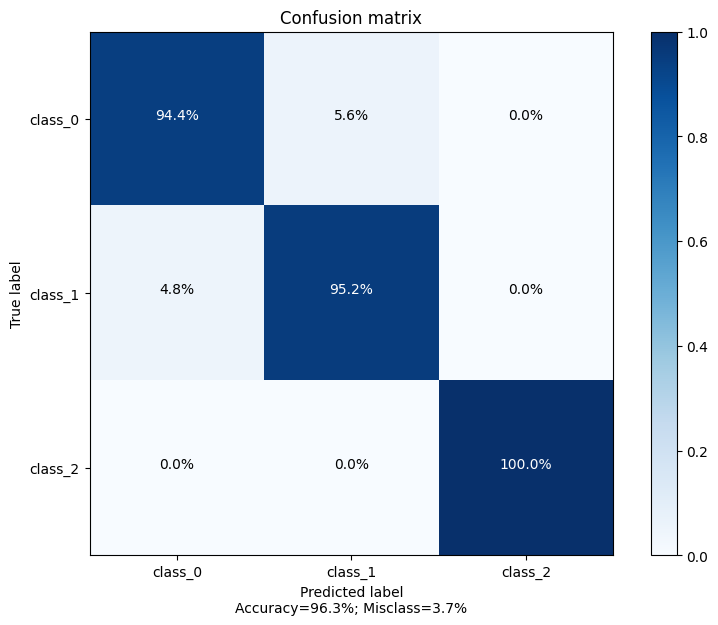

In [13]:
cm_display = plot_confusion_matrix(cm_test, target_names=dat.target_names)

A modell jellemzésére egyéb mérőszámokat is meghatározhatunk a tévesztészi mátrix egyes elemeiből:

In [14]:
# Egyéb modell pontosságot leíró mérőszámok kiszámítása és kiíratása
print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_mlp)))
print("Other metrics based on test data: \n",classification_report(y_test,y_pred_mlp, target_names = dat.target_names))

Model accuracy: 0.9630
Other metrics based on test data: 
               precision    recall  f1-score   support

     class_0       0.94      0.94      0.94        18
     class_1       0.95      0.95      0.95        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.96      0.96      0.96        54

